In [1]:
using GraphViz

using StockFlow
using StockFlow.Syntax

using Catlab
using Catlab.CategoricalAlgebra
using LabelledArrays
using OrdinaryDiffEq
using Plots

using Catlab.Graphics
using Catlab.Programs
using Catlab.WiringDiagrams

using Catlab.Graphics.Graphviz: Html
using Catlab.Graphics.Graphviz

In [2]:
# Functions for graphing typed Petri nets
colors_vflow = ["antiquewhite4","antiquewhite", "gold", "saddlebrown", "slateblue", "blueviolet", "olive"]
colors_s = ["deeppink","darkorchid","darkred","coral"] # red series
colors_sv = ["cornflowerblue","cyan4","cyan","chartreuse"] # green and blue series
colors_p = ["gold","gold4","darkorange1","lightgoldenrod","goldenrod"] # yellow and orange

flatten(fname::Symbol) = "$fname"

function flatten(fname::Tuple)
    names = split(replace(string(fname), "("=>"", ")"=>"", ":"=>""), ",")
    for i in 1:length(names)
        name = strip(names[i])
        if name[1:2] == "id"
            continue
        end
        return name
    end
    return "id"
end

def_stock(typed_StockFlow::ACSetTransformation, colors) = 
  (p,s) -> ("s$s", Attributes(:label=>sname(p,s) isa Tuple where T ? Html(replace(string(sname(p,s)), ":"=>"", "," => "<BR/>", "("=>"", ")"=>"")) : "$(sname(p,s))",
                                     :shape=>"square", 
                                     :color=>"black", 
                                     :style=>"filled", 
                                     :fillcolor=>colors[typed_StockFlow[:S](s)]))

def_parameter(typed_StockFlow::ACSetTransformation, colors) = 
(p, pp) -> ("p$pp", Attributes(:label=>pname(p,pp) isa Tuple where T ? Html(replace(string(pname(p,pp)), ":"=>"", "," => "<BR/>", "("=>"", ")"=>"")) : "$(pname(p,pp))",
                                     :shape=>"circle", 
                                     :color=>colors[typed_StockFlow[:P](pp)],
                                     :fontcolor=>colors[typed_StockFlow[:P](pp)]))

def_auxiliaryVF(typed_StockFlow::ACSetTransformation, colors)=
  (p, v) -> ("v$v", Attributes(:label=>make_v_expr(p,v) isa Tuple where T ? Html(replace(string(make_v_expr(p,v)), ":"=>"", "," => "<BR/>", "("=>"", ")"=>"")) : "$(make_v_expr(p,v))",
                                          :shape=>"plaintext", 
                                          :fontcolor=>colors[typed_StockFlow[:V](v)]))


def_sumV(typed_StockFlow::ACSetTransformation, colors) = 
  (p, sv) -> ("sv$sv", Attributes(:label=>svname(p,sv) isa Tuple where T ? Html(replace(string(svname(p,sv)), ":"=>"", "," => "<BR/>", "("=>"", ")"=>"")) : "$(svname(p,sv))",
                                       :shape=>"circle", 
                                       :color=>"black",
                                       :fillcolor=>colors[typed_StockFlow[:SV](sv)], 
                                       :style=>"filled"))  


def_flow_V(typed_StockFlow::ACSetTransformation, colors)=
  (p, us, ds, v, f) -> begin
    labelfontsize = "6"
    colorType = colors[typed_StockFlow[:F](f)]
    color = "$colorType"*":invis:"*"$colorType"
    arrowhead = "none"
    splines = "ortho"
    return ([us, "v$v"],Attributes(:label=>"", :labelfontsize=>labelfontsize, :color=>color, :arrowhead=>arrowhead, :splines=>splines)),
           (["v$v", ds],Attributes(:label=>Html(flatten(fname(p,f))), :labelfontsize=>labelfontsize, :color=>color, :splines=>splines))            
end
        
def_flow_noneV(typed_StockFlow::ACSetTransformation, colors)=
  (p, us, ds, f) -> begin
     colorType = colors[typed_StockFlow[:F](f)]
     color = "$colorType"*":invis:"*"$colorType"   
     ([us, ds],Attributes(:label=>Html(flatten(fname(p,f))), :labelfontsize=>"6", :color=>color))
end

def_flow_V(colors = colors_vflow)=
  (p, us, ds, v, f) -> begin
    labelfontsize = "6"
    colorType = colors[f]
    color = "$colorType"*":invis:"*"$colorType"
    arrowhead = "none"
    splines = "ortho"
    return ([us, "v$v"],Attributes(:label=>"", :labelfontsize=>labelfontsize, :color=>color, :arrowhead=>arrowhead, :splines=>splines)),
           (["v$v", ds],Attributes(:label=>Html(flatten(fname(p,f))), :labelfontsize=>labelfontsize, :color=>color, :splines=>splines))            
    
end
        
def_flow_noneV(colors = colors_vflow)=
  (p, us, ds, f) -> begin
     colorType = colors[f]
     color = "$colorType"*":invis:"*"$colorType"   
     ([us, ds],Attributes(:label=>Html(flatten(fname(p,f))), :labelfontsize=>"6", :color=>color))
end

GraphF_typed(typed_StockFlow::ACSetTransformation, colors_vflow = colors_vflow, colors_s = colors_s, colors_p = colors_p, colors_sv = colors_sv; schema::String="C", type::String="SFVL", rd::String="LR") = GraphF(dom(typed_StockFlow),
    make_stock = def_stock(typed_StockFlow, colors_s), make_auxiliaryV=def_auxiliaryVF(typed_StockFlow, colors_vflow), make_sumV=def_sumV(typed_StockFlow, colors_sv), 
    make_flow_V=def_flow_V(typed_StockFlow, colors_vflow), make_flow_noneV=def_flow_noneV(typed_StockFlow, colors_vflow),make_parameter=def_parameter(typed_StockFlow, colors_p),schema=schema, type=type, rd=rd
)
            
flatten(k::Nothing) = "nothing"
            
            

flatten (generic function with 3 methods)

In [13]:
seir_nodeaths = @stock_and_flow begin
    :stocks
    S
    E
    I
    R

    :parameters
    μ
    β
    tlatent
    trecovery
    # δ
    c

    :dynamic_variables
    v_birth = μ * N
    v_inf = E / tlatent
    # v_deathE = E * δ
    v_rec = I / trecovery
    # v_deathI = I * δ
    # v_deathR = R * δ
    # v_deathS = S * δ
    
    v_prevalence = I / N
    v_meanInfectiousContactsPerS = c * v_prevalence
    v_perSIncidenceRate = β * v_meanInfectiousContactsPerS
    v_newInfections = S * v_perSIncidenceRate




    :flows
    CLOUD => f_birth(v_birth) => S
    S => f_incid(v_newInfections) => E
    # S => f_deathS(v_deathS) => CLOUD
    E => f_inf(v_inf) => I
    # E => f_deathE(v_deathE) => CLOUD
    I => f_rec(v_rec) => R
    # I => f_deathI(v_deathI) => CLOUD
    # R => f_deathR(v_deathR) => CLOUD

    :sums
    N = [S, E, I, R]
    NI = [I]
    NS = [S, E]

end;




In [130]:
seir_nodeaths_feet2 = Open(seir_nodeaths,

foot(:S,:N,:S=>:N),
foot(:E,:N,:E=>:N),
foot(:I,:N,:I=>:N),
foot(:R,:N,:R=>:N),

)

StructuredMulticospan{Catlab.CategoricalAlgebra.StructuredCospans.DiscreteACSet{StockAndFlow0, StockAndFlowF}, SMulticospan{4, StockAndFlowF, StructTightACSetTransformation{TypeLevelBasicSchema{Symbol, Tuple{:S, :SV, :LS, :F, :I, :O, :V, :LV, :LSV, :P, :LVV, :LPV}, Tuple{(:lss, :LS, :S), (:lssv, :LS, :SV), (:ifn, :I, :F), (:is, :I, :S), (:ofn, :O, :F), (:os, :O, :S), (:fv, :F, :V), (:lvs, :LV, :S), (:lvv, :LV, :V), (:lsvsv, :LSV, :SV), (:lsvv, :LSV, :V), (:lvsrc, :LVV, :V), (:lvtgt, :LVV, :V), (:lpvp, :LPV, :P), (:lpvv, :LPV, :V)}, Tuple{:Name, :Op, :Position}, Tuple{(:sname, :S, :Name), (:svname, :SV, :Name), (:fname, :F, :Name), (:vname, :V, :Name), (:pname, :P, :Name), (:vop, :V, :Op), (:lvsposition, :LV, :Position), (:lsvsvposition, :LSV, :Position), (:lvsrcposition, :LVV, :Position), (:lpvpposition, :LPV, :Position)}}, NamedTuple{(:S, :SV, :LS, :F, :I, :O, :V, :LV, :LSV, :P, :LVV, :LPV), Tuple{Catlab.CategoricalAlgebra.FinSets.FinDomFunctionVector{Int64, Vector{Int64}, Catlab.Cate

In [261]:
 
*(x::Symbol, y::Symbol) = Symbol(String(x) * String(y))

 #(stock_name=>(inflows, outflows, variables, svariables))
     ## if a stock has no inflow or no outflow, use keyword ":F_NONE"
     ## if a stock has no variables connect to, use keyword ":V_NONE"
     ## if a stock has no sum_variables connect to, use keyword ":SV_NONE"
#(flow=>variable)
#(variable=>function)
#(svariable=>variable)
     ## if sum_variable contributes to no variables, use keywork ":SVV_NONE"
 
 function deaths_model(suf=Symbol()::Symbol)

    stock = suf
    f_id = :f_id * suf
    f_deaths = :f_deaths * suf
    δ = :δ



    StockAndFlowF(
        


    )


#     @stock_and_flow begin
#     :stocks
#     X

#     :parameters
#     δ
#     r

#     :dynamic_variables
#     v_deaths = δ * X
#     v_id = r * X

#     :flows
#     X => f_deaths(v_deaths) => CLOUD
#     X => f_id(v_id) => X

#     :sums
#     N = [X]
#     NI = [X]
#     NS = []

# end
end

deaths_model (generic function with 2 methods)

:AB

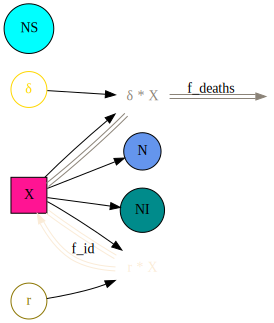

In [260]:
GraphF_typed(id(deaths_model()))

In [255]:
uwd = @relation (a,b,c) begin
    X(a,c)
    X(b,c)
end
# println(uwd)

Catlab.Programs.RelationalPrograms.UntypedUnnamedRelationDiagram{Symbol, Symbol} with elements Box = 1:2, Port = 1:4, OuterPort = 1:3, Junction = 1:3
┌─────┬──────┐
│ Box │ name │
├─────┼──────┤
│   1 │    X │
│   2 │    X │
└─────┴──────┘
┌──────┬─────┬──────────┐
│ Port │ box │ junction │
├──────┼─────┼──────────┤
│    1 │   1 │        1 │
│    2 │   1 │        3 │
│    3 │   2 │        2 │
│    4 │   2 │        3 │
└──────┴─────┴──────────┘
┌───────────┬────────────────┐
│ OuterPort │ outer_junction │
├───────────┼────────────────┤
│         1 │              1 │
│         2 │              2 │
│         3 │              3 │
└───────────┴────────────────┘
┌──────────┬──────────┐
│ Junction │ variable │
├──────────┼──────────┤
│        1 │        a │
│        2 │        b │
│        3 │        c │
└──────────┴──────────┘

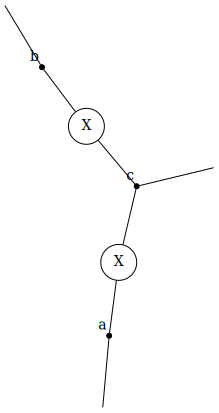

In [256]:
display_uwd(uwd)

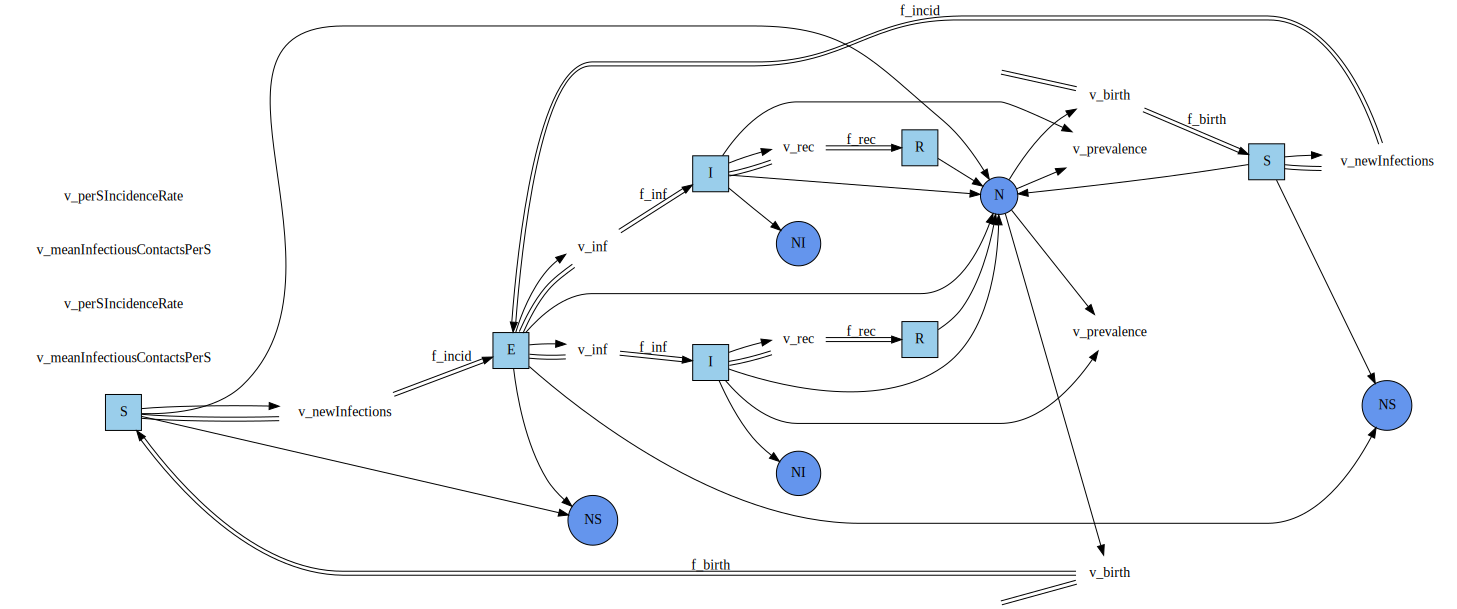

In [257]:
nodifferencemodel = oapply(uwd,Dict(
    :X => seir_nodeaths_feet2,
    :Y => seir_nodeaths_feet
    )) |> apex
Graph(nodifferencemodel)